In [1]:
import numpy as np
from gensim import corpora, models
import gensim
import csv
import _pickle as cPickle
from sklearn.externals import joblib
import bz2
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy import stats
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
%%time 


# Load to memory
corpus = gensim.corpora.MmCorpus('data/eos/processed_unigram_corpus_EOS.mm')
dictionary = gensim.corpora.Dictionary.load_from_text('data/eos/unigram_dictionary_EOS.txt')
ldamodel = joblib.load('data/eos/LDAmodel_unigram_20_EOS.pkl')


CPU times: user 4.92 s, sys: 104 ms, total: 5.02 s
Wall time: 5.01 s


In [4]:
%%time


color = []
for corpus_line in corpus:
    sorted_topic_line = list(sorted(ldamodel[corpus_line], key=lambda x: x[1], reverse=True))
    color.append(sorted_topic_line[0][0])
    
    
lda_output = []
for line in corpus:
    lda_output.append(ldamodel[line])
    
topics_data = np.zeros(shape=(len(corpus), 20))

for i, line in enumerate(lda_output):
    for topic_line in line:
            topics_data[i][topic_line[0]] = topic_line[1]

CPU times: user 1h 10min 15s, sys: 3h 37min 18s, total: 4h 47min 33s
Wall time: 41min 45s


CPU times: user 1.88 s, sys: 452 ms, total: 2.33 s
Wall time: 1.23 s


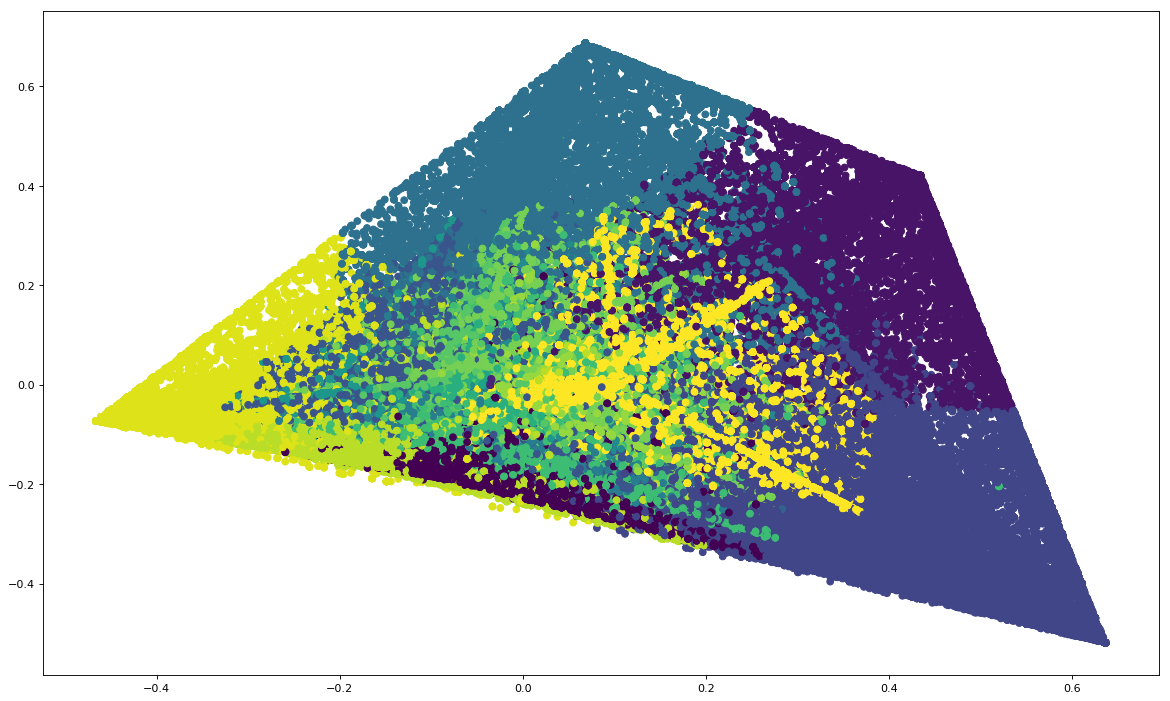

In [5]:
%%time

X_pca = PCA().fit_transform(topics_data)
figure(num=None, figsize=(18, 11), dpi=80, facecolor='w', edgecolor='k')
scatter(X_pca[:, 0], X_pca[:, 1], c=color)

CPU times: user 1.81 s, sys: 560 ms, total: 2.37 s
Wall time: 1.25 s


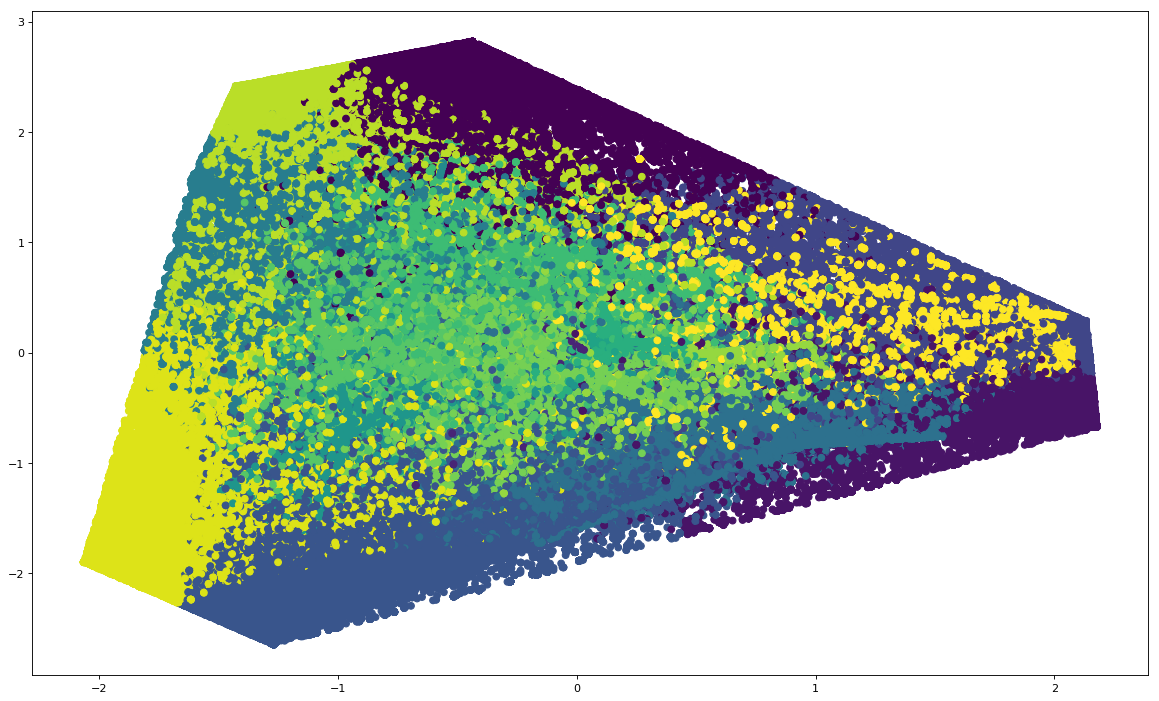

In [6]:
%%time


topics_data_norm  = stats.zscore(topics_data, axis=0)

X_pca = PCA().fit_transform(topics_data_norm )
figure(num=None, figsize=(18, 11), dpi=80, facecolor='w', edgecolor='k')
scatter(X_pca[:, 0], X_pca[:, 1], c=color)

(924394, 20)
462197
(924394, 20)
CPU times: user 34.8 s, sys: 764 ms, total: 35.5 s
Wall time: 33.7 s


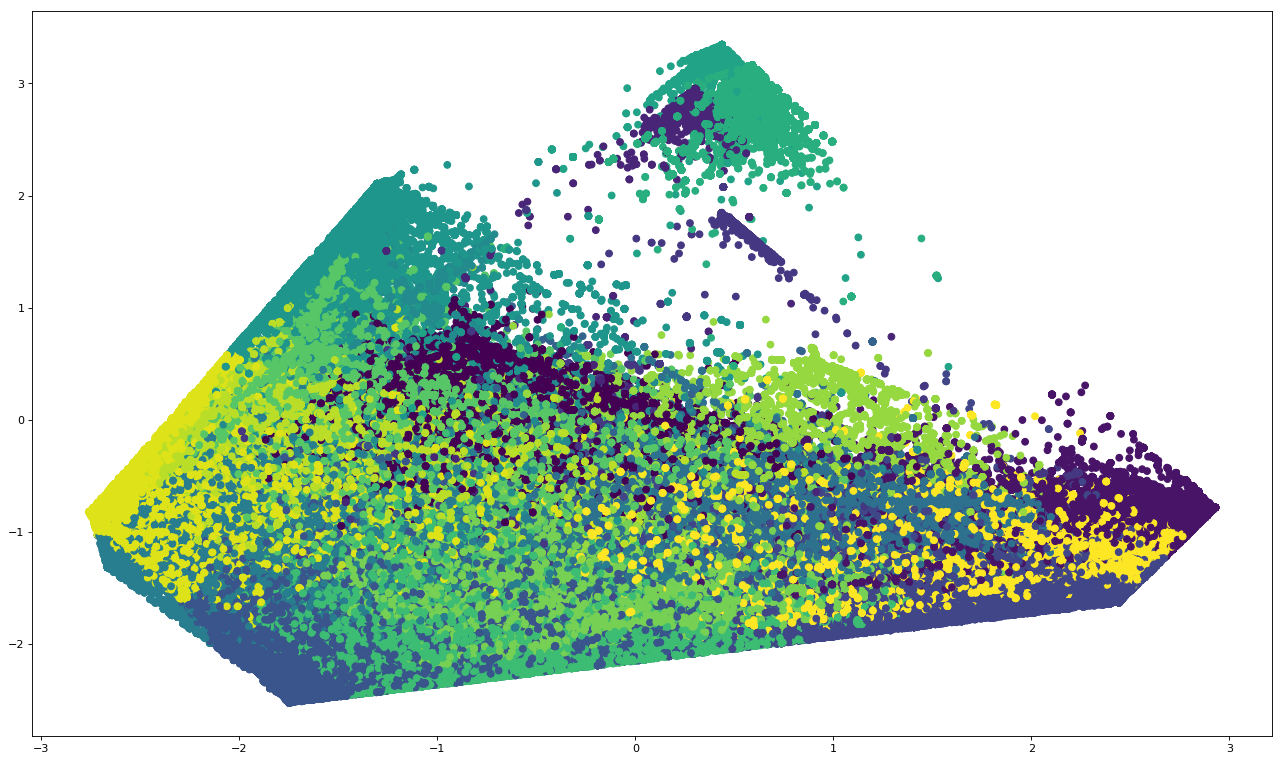

In [8]:
%%time

topics_data = np.zeros(shape=(len(corpus) * 2, 20))

print (topics_data.shape)
print(len(lda_output))

for i, line in enumerate(lda_output):
    for topic_line in line:
            topics_data[i][topic_line[0]] = topic_line[1]
         
topics_data_norm = stats.zscore(topics_data, axis=0)

print(topics_data_norm.shape)

color = []
for line in topics_data_norm:
    color_number =[i for i, j in enumerate(line) if j == max(line)]
    color.append(int(color_number[0]))

X_pca = PCA().fit_transform(topics_data_norm )
figure(num=None, figsize=(20, 12), dpi=80, facecolor='w', edgecolor='k')
scatter(X_pca[:, 0], X_pca[:, 1], c=color)

# TSNE

In [14]:
from sklearn.manifold import TSNE

# a t-SNE model
# angle value close to 1 means sacrificing accuracy for speed
# pca initializtion usually leads to better results 
# tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')


# doc_topic_distr = ldamodel.fit_transform()
# 20-D -> 2-D
# tsne_lda = tsne_model.fit_transform(doc_topic_distr)
